Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
!pip install visualkeras
import visualkeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 992.2/992.2 KB 16.1 MB/s eta 0:00:00


In [2]:
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip /content/drive/MyDrive/ColabNotebooks/Upgrad-14-10/CaseStudy/CNNSkinCancer/CNN_assignment.zip

Archive:  /content/drive/MyDrive/ColabNotebooks/Upgrad-14-10/CaseStudy/CNNSkinCancer/CNN_assignment.zip
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010512.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010889.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024468.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024470.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024511.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024646.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024654.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Te

In [4]:
import pathlib
data_dir = "Skin cancer ISIC The International Skin Imaging Collaboration"
data_dir = pathlib.Path(data_dir)
print(data_dir)

Skin cancer ISIC The International Skin Imaging Collaboration


In [5]:
image_count = len(list(data_dir.glob('**/*.jpg')))
print(image_count)

2357


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [6]:
# Defining the path for train and test images
data_dir_train = pathlib.Path(os.path.join(data_dir,'Train'))
data_dir_test = pathlib.Path(os.path.join(data_dir,'Test'))

In [7]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [8]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [9]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [10]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [11]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

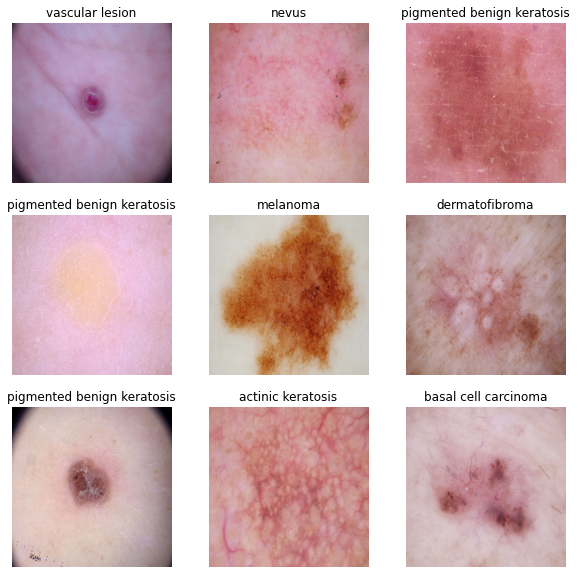

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

In [13]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [14]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [15]:
num_classes = len(class_names)
print("Number of clasess: ",num_classes)

Number of clasess:  9


### Create the model
####CNN model, which can accurately detect 9 classes present in the dataset. 

In [16]:
model = Sequential([
    # Rescaling the input image to [0,1]
    layers.Rescaling(255, input_shape=(img_height, img_width, 3)),
    # Convlution layer with 16 filters and of size [3,3]
    # Padding and stride set to 1 to get the same to make sure output is same size as input
    # Activation function used `relu`
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    # Max pooling down sizes the output by facotr of 2 across height * width
    # Resulting in size of [90,90,16]
    layers.MaxPooling2D(),

    # Convlution layer with 32 filters and of size [3,3]
    # Padding and stride set to 1 to get the same to make sure output is same size as input
    # Activation function used `relu`
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    # Max pooling down sizes the output by facotr of 2 across height * width
    # Resulting in size of [45,45,32]
    layers.MaxPooling2D(),

    # Convlution layer with 64 filters and of size [3,3]
    # Padding and stride set to 1 to get the same to make sure output is same size as input
    # Activation function used `relu`
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    # Max pooling down sizes the output by facotr of 2 across height * width
    # Resulting in size of [22,22,64]
    layers.MaxPooling2D(),
  
    # Convlution layer with 128 filters and of size [3,3]
    # Padding and stride set to 1 to get the same to make sure output is same size as input
    # Activation function used `relu`
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    # Max pooling down sizes the output by facotr of 2 across height * width
    # Resulting in size of [11,11,128]
    layers.MaxPooling2D(),
  
    # Flatten the output to feed to Denese network
    # After fattening number we get [22*22*256] Size array
    layers.Flatten(),
    # Adding a dense layer of 1024 neurons.
    layers.Dense(1024, activation='relu'),
    # Adding a dense layer of 9 neurons which is number of classification's we have.
    layers.Dense(num_classes, activation='softmax')
])

#### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [17]:
# Lets use standard gradiant descent as optimizer
model.compile(optimizer='adam',
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

In [18]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 batch_normalization (BatchN  (None, 180, 180, 16)     64        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 batch_normalization_1 (Batc  (None, 90, 90, 32)       1

#### Train the model

In [19]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 15s 33ms/step - loss: 8.0755 - accuracy: 0.3610 - val_loss: 4.1666 - val_accuracy: 0.1946
Epoch 2/20
56/56 [==============================] - 1s 15ms/step - loss: 2.2160 - accuracy: 0.4754 - val_loss: 2.0429 - val_accuracy: 0.3356
Epoch 3/20
56/56 [==============================] - 1s 15ms/step - loss: 1.4559 - accuracy: 0.5558 - val_loss: 1.7646 - val_accuracy: 0.3691
Epoch 4/20
56/56 [==============================] - 1s 15ms/step - loss: 1.1426 - accuracy: 0.6021 - val_loss: 2.3369 - val_accuracy: 0.3177
Epoch 5/20
56/56 [==============================] - 1s 15ms/step - loss: 1.0135 - accuracy: 0.6551 - val_loss: 1.5008 - val_accuracy: 0.4877
Epoch 6/20
56/56 [==============================] - 1s 15ms/step - loss: 0.8701 - accuracy: 0.6992 - val_loss: 1.6035 - val_accuracy: 0.4944
Epoch 7/20
56/56 [==============================] - 1s 15ms/step - loss: 0.7647 - accuracy: 0.7249 - val_loss: 1.5017 - val_accuracy: 0.5391
Epoch 8/20
5

#### Visualizing training results

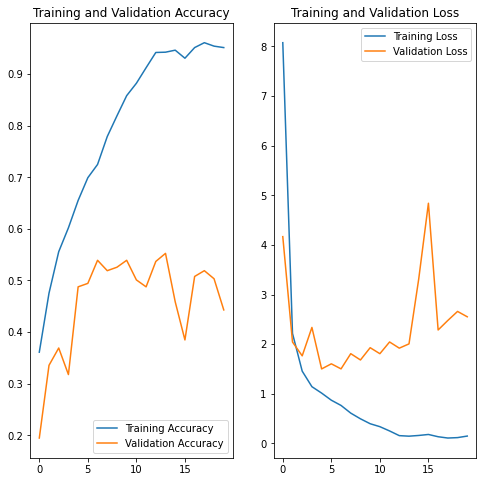

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

####Overfitting
Differnce between training and validation is big enough to call for overfitting. Train accuracy is 0.96 and validation accuracy is 0.55. 
Even though Training accuracy is growing liniearly, Validation accuracy max out at 55%. This shows the model is overfitting.

### Data augmentation
In both the models we analyzed are underfitting or over fitting. This is due to low number of samples we have for training. We can add some more images by randomly adding images that are generated from exisitng images

In [21]:
image_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical",input_shape=(img_height, img_width, 3)),
    layers.RandomRotation(0.2, fill_mode='nearest'),
    layers.RandomZoom(0.2),
  ],name="Image_Augmentation_Layer")

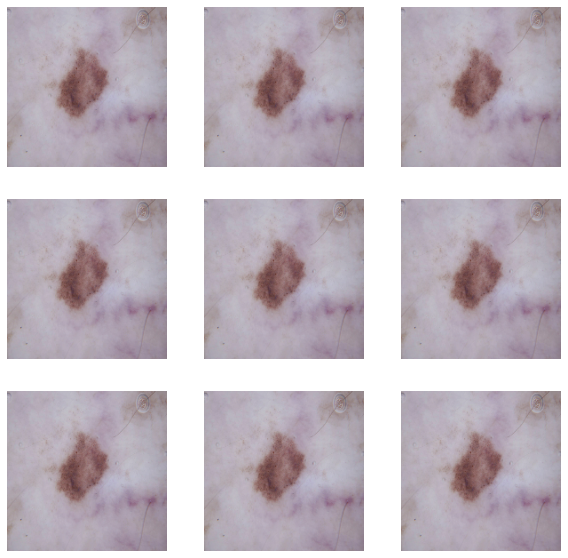

In [22]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = image_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")


### Augumented data: Create the model, compile and train the model


In [23]:
model = Sequential([
    image_augmentation,
    # Rescaling the input image to [0,1]
    layers.Rescaling(255, input_shape=(img_height, img_width, 3)),
    # Convlution layer with 16 filters and of size [3,3]
    # Padding and stride set to 1 to get the same to make sure output is same size as input
    # Activation function used `relu`
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    # Max pooling down sizes the output by facotr of 2 across height * width
    # Resulting in size of [90,90,16]
    layers.MaxPooling2D(),

    # Convlution layer with 32 filters and of size [3,3]
    # Padding and stride set to 1 to get the same to make sure output is same size as input
    # Activation function used `relu`
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    # Max pooling down sizes the output by facotr of 2 across height * width
    # Resulting in size of [45,45,32]
    layers.MaxPooling2D(),

    # Convlution layer with 64 filters and of size [3,3]
    # Padding and stride set to 1 to get the same to make sure output is same size as input
    # Activation function used `relu`
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    # Max pooling down sizes the output by facotr of 2 across height * width
    # Resulting in size of [22,22,64]
    layers.MaxPooling2D(),
  
    # Convlution layer with 128 filters and of size [3,3]
    # Padding and stride set to 1 to get the same to make sure output is same size as input
    # Activation function used `relu`
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    # Max pooling down sizes the output by facotr of 2 across height * width
    # Resulting in size of [11,11,128]
    layers.MaxPooling2D(),
  
    # Flatten the output to feed to Denese network
    # After fattening number we get [22*22*256] Size array
    layers.Flatten(),
    # Adding a dense layer of 1024 neurons.
    layers.Dense(1024, activation='relu'),
    # Adding a dense layer of 9 neurons which is number of classification's we have.
    layers.Dense(num_classes, activation='softmax')
])

#### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [24]:
# Lets use standard gradiant descent as optimizer
model.compile(optimizer='adam',
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

In [25]:
# View the summary of all layers
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Image_Augmentation_Layer (S  (None, 180, 180, 3)      0         
 equential)                                                      
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 batch_normalization_4 (Batc  (None, 180, 180, 16)     64        
 hNormalization)                                                 
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                      

#### Train the model

In [26]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 4s 35ms/step - loss: 5.7292 - accuracy: 0.3538 - val_loss: 7.5025 - val_accuracy: 0.2662
Epoch 2/20
56/56 [==============================] - 2s 33ms/step - loss: 1.8229 - accuracy: 0.4632 - val_loss: 4.0710 - val_accuracy: 0.3960
Epoch 3/20
56/56 [==============================] - 2s 32ms/step - loss: 1.6217 - accuracy: 0.4894 - val_loss: 3.1124 - val_accuracy: 0.3960
Epoch 4/20
56/56 [==============================] - 2s 32ms/step - loss: 1.3816 - accuracy: 0.5218 - val_loss: 2.1059 - val_accuracy: 0.5190
Epoch 5/20
56/56 [==============================] - 2s 32ms/step - loss: 1.3087 - accuracy: 0.5441 - val_loss: 1.8739 - val_accuracy: 0.5123
Epoch 6/20
56/56 [==============================] - 2s 32ms/step - loss: 1.2819 - accuracy: 0.5441 - val_loss: 3.4160 - val_accuracy: 0.3356
Epoch 7/20
56/56 [==============================] - 2s 32ms/step - loss: 1.2542 - accuracy: 0.5519 - val_loss: 2.1543 - val_accuracy: 0.3423
Epoch 8/20
56

#### Visualizing training results

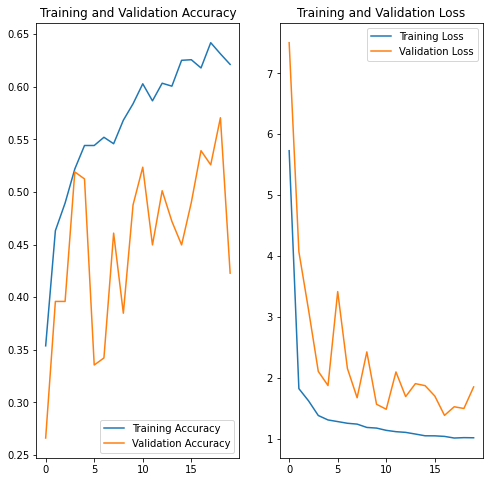

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

####Overfitting
Differnce between training and validation is big enough to call for overfitting. Train accuracy is 0.62 and validation accuracy is 0.44. 
Even though Training accuracy is growing liniearly, Validation accuracy max out at 52%. This shows the model is overfitting.

###SecondModel with DropOut's
Lets try the same model with dropout's

In [28]:
model = Sequential([
    image_augmentation,
    # Rescaling the input image to [0,1]
    layers.Rescaling(255, input_shape=(img_height, img_width, 3)),
    # Convlution layer with 16 filters and of size [3,3]
    # Padding and stride set to 1 to get the same to make sure output is same size as input
    # Activation function used `relu`
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    # Max pooling down sizes the output by facotr of 2 across height * width
    # Resulting in size of [90,90,16]
    layers.MaxPooling2D(),
    layers.Dropout(0.25),

    # Convlution layer with 32 filters and of size [3,3]
    # Padding and stride set to 1 to get the same to make sure output is same size as input
    # Activation function used `relu`
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    # Max pooling down sizes the output by facotr of 2 across height * width
    # Resulting in size of [45,45,32]
    layers.MaxPooling2D(),
    layers.Dropout(0.25),

    # Convlution layer with 64 filters and of size [3,3]
    # Padding and stride set to 1 to get the same to make sure output is same size as input
    # Activation function used `relu`
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    # Max pooling down sizes the output by facotr of 2 across height * width
    # Resulting in size of [22,22,64]
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
  
    # Convlution layer with 128 filters and of size [3,3]
    # Padding and stride set to 1 to get the same to make sure output is same size as input
    # Activation function used `relu`
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    # Max pooling down sizes the output by facotr of 2 across height * width
    # Resulting in size of [11,11,128]
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
  
    # Flatten the output to feed to Denese network
    # After fattening number we get [22*22*256] Size array
    layers.Flatten(),
    # Adding a dense layer of 1024 neurons.
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.50),
    # Adding a dense layer of 9 neurons which is number of classification's we have.
    layers.Dense(num_classes, activation='softmax')
])

#### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [29]:
# Lets use standard gradiant descent as optimizer
model.compile(optimizer='adam',
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

In [30]:
# View the summary of all layers
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Image_Augmentation_Layer (S  (None, 180, 180, 3)      0         
 equential)                                                      
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 batch_normalization_8 (Batc  (None, 180, 180, 16)     64        
 hNormalization)                                                 
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                      

#### Train the model

In [31]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 4s 35ms/step - loss: 8.3186 - accuracy: 0.2919 - val_loss: 6.0892 - val_accuracy: 0.2215
Epoch 2/20
56/56 [==============================] - 2s 32ms/step - loss: 3.2960 - accuracy: 0.3359 - val_loss: 2.2436 - val_accuracy: 0.3893
Epoch 3/20
56/56 [==============================] - 2s 32ms/step - loss: 2.2430 - accuracy: 0.3622 - val_loss: 1.8374 - val_accuracy: 0.3579
Epoch 4/20
56/56 [==============================] - 2s 32ms/step - loss: 1.7169 - accuracy: 0.4169 - val_loss: 1.6735 - val_accuracy: 0.4206
Epoch 5/20
56/56 [==============================] - 2s 32ms/step - loss: 1.6455 - accuracy: 0.4336 - val_loss: 1.6084 - val_accuracy: 0.4541
Epoch 6/20
56/56 [==============================] - 2s 32ms/step - loss: 1.5781 - accuracy: 0.4386 - val_loss: 1.6464 - val_accuracy: 0.4720
Epoch 7/20
56/56 [==============================] - 2s 32ms/step - loss: 1.6036 - accuracy: 0.4487 - val_loss: 2.4321 - val_accuracy: 0.3378
Epoch 8/20
56

#### Visualizing training results

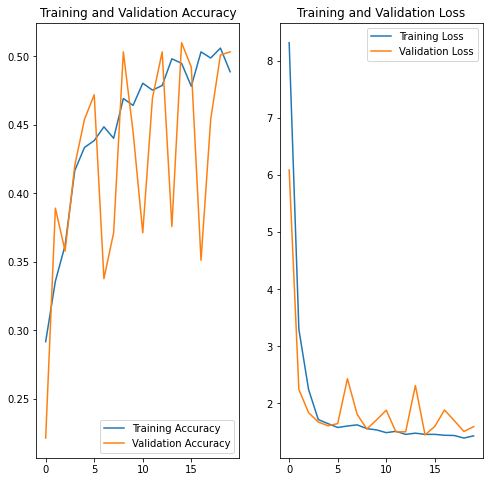

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Train accuracy: 0.4888  and Test val_accuracy: 0.4653 Shows that there is no overfitting, and also the accuracy is growing linearly. Adding more data and running for more epoche can improbe the accuracy.

### Distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [33]:
class_data = {}
for sub_dir in data_dir_train.iterdir():
  class_data[os.path.basename(sub_dir)]= [len(list(sub_dir.iterdir())), round((len(list(sub_dir.iterdir()))*100)/image_count_train,2)]

class_df = pd.DataFrame.from_dict(class_data, orient='index',columns=['No of elements', 'Pct of elements'])    
class_df

,No of elements,Pct of elements
squamous cell carcinoma,181,8.08
basal cell carcinoma,376,16.79
nevus,357,15.94
actinic keratosis,114,5.09
seborrheic keratosis,77,3.44
pigmented benign keratosis,462,20.63
vascular lesion,139,6.21
dermatofibroma,95,4.24
melanoma,438,19.56


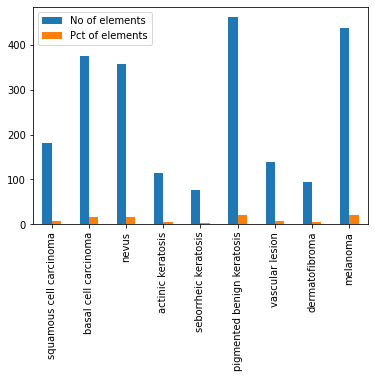

In [34]:
class_df.plot.bar()
plt.show()

#### Findings: 
- `seborrheic keratosis` class has least number of samples, `dermatofibroma` and `vascular lesion` are close by with very small number of samples.
- `pigmented benign keratosis` have the highest percentage of data at 20%. `melanoma` us close by at 19.56% and `basal cell carcinoma` with 16.8%


#### Rectify the class imbalance

In [35]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [36]:
path_to_training_dataset=data_dir_train
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(os.path.join(path_to_training_dataset,i))
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F81FC808E50>: 100%|██████████| 500/500 [00:03<00:00, 127.53 Samples/s]


Initialised with 376 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F82A3A1E160>: 100%|██████████| 500/500 [00:04<00:00, 120.75 Samples/s]


Initialised with 95 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F81FC7B2790>: 100%|██████████| 500/500 [00:04<00:00, 124.26 Samples/s]


Initialised with 438 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F81FC36BCD0>: 100%|██████████| 500/500 [00:15<00:00, 32.99 Samples/s]


Initialised with 357 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F82A3AF2F70>: 100%|██████████| 500/500 [00:14<00:00, 35.57 Samples/s]


Initialised with 462 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F82A3B0C490>: 100%|██████████| 500/500 [00:03<00:00, 145.30 Samples/s]


Initialised with 77 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F822C1A1340>: 100%|██████████| 500/500 [00:07<00:00, 70.53 Samples/s]


Initialised with 181 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F81FC7EB550>: 100%|██████████| 500/500 [00:03<00:00, 141.48 Samples/s]


Initialised with 139 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F82A3B362B0>: 100%|██████████| 500/500 [00:03<00:00, 142.86 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [37]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


#### Lets see the distribution of augmented data after adding new images to the original training data.

In [38]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0026132.jpg_7b586d20-fbee-4ce6-a9e2-131e686bebc0.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0031692.jpg_3ca75016-6bd3-4b3e-9a74-7cd89170b84e.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0027930.jpg_f47884a5-6394-4f85-b135-9638596268e8.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0025831.jpg_f77f3db7-14fe-47b0-849a-1f15cbf7e9bc.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0031918.jpg_9bd680e9-d582-485b-8792-e33dce8d4bae.jpg',
 'Skin cancer ISIC The Interna

In [39]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]

In [40]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [41]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
df2

,Path,Label
0,Skin cancer ISIC The International Skin Imagin...,squamous cell carcinoma
1,Skin cancer ISIC The International Skin Imagin...,squamous cell carcinoma
2,Skin cancer ISIC The International Skin Imagin...,squamous cell carcinoma
3,Skin cancer ISIC The International Skin Imagin...,squamous cell carcinoma
4,Skin cancer ISIC The International Skin Imagin...,squamous cell carcinoma
...,...,...
4495,Skin cancer ISIC The International Skin Imagin...,melanoma
4496,Skin cancer ISIC The International Skin Imagin...,melanoma
4497,Skin cancer ISIC The International Skin Imagin...,melanoma
4498,Skin cancer ISIC The International Skin Imagin...,melanoma


In [42]:
df2['Label'].value_counts()

squamous cell carcinoma       500
basal cell carcinoma          500
nevus                         500
actinic keratosis             500
seborrheic keratosis          500
pigmented benign keratosis    500
vascular lesion               500
dermatofibroma                500
melanoma                      500
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

In [43]:
# Defining the path for train and test images
data_dir_train = pathlib.Path(os.path.join(data_dir,'Train'))
data_dir_test = pathlib.Path(os.path.join(data_dir,'Test'))

In [44]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

4500
118


####Create a training dataset

In [45]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


####Create a validation dataset

In [46]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


###SecondModel with DropOut's
Lets try the same model with dropout's

In [60]:
model = Sequential([
    image_augmentation,
    # Rescaling the input image to [0,1]
    layers.Rescaling(255, input_shape=(img_height, img_width, 3)),
    # Convlution layer with 16 filters and of size [3,3]
    # Padding and stride set to 1 to get the same to make sure output is same size as input
    # Activation function used `relu`
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    # Max pooling down sizes the output by facotr of 2 across height * width
    # Resulting in size of [90,90,16]
    layers.MaxPooling2D(),
    layers.Dropout(0.25),

    # Convlution layer with 32 filters and of size [3,3]
    # Padding and stride set to 1 to get the same to make sure output is same size as input
    # Activation function used `relu`
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    # Max pooling down sizes the output by facotr of 2 across height * width
    # Resulting in size of [45,45,32]
    layers.MaxPooling2D(),
    layers.Dropout(0.25),

    # Convlution layer with 64 filters and of size [3,3]
    # Padding and stride set to 1 to get the same to make sure output is same size as input
    # Activation function used `relu`
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    # Max pooling down sizes the output by facotr of 2 across height * width
    # Resulting in size of [22,22,64]
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
  
    # Convlution layer with 128 filters and of size [3,3]
    # Padding and stride set to 1 to get the same to make sure output is same size as input
    # Activation function used `relu`
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    # Max pooling down sizes the output by facotr of 2 across height * width
    # Resulting in size of [11,11,128]
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
  
    # Flatten the output to feed to Denese network
    # After fattening number we get [22*22*256] Size array
    layers.Flatten(),
    # Adding a dense layer of 1024 neurons.
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.50),
    # Adding a dense layer of 9 neurons which is number of classification's we have.
    layers.Dense(num_classes, activation='softmax')
])

#### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [61]:
# Lets use standard gradiant descent as optimizer
model.compile(optimizer='adam',
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

In [62]:
# View the summary of all layers
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Image_Augmentation_Layer (S  (None, 180, 180, 3)      0         
 equential)                                                      
                                                                 
 rescaling_5 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_20 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 batch_normalization_20 (Bat  (None, 180, 180, 16)     64        
 chNormalization)                                                
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 90, 90, 16)       0         
 g2D)                                                            
                                                      

#### Train the model

In [63]:
epochs = 50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
169/169 [==============================] - 10s 50ms/step - loss: 5.4693 - accuracy: 0.2656 - val_loss: 3.9336 - val_accuracy: 0.1871
Epoch 2/50
169/169 [==============================] - 9s 49ms/step - loss: 1.9276 - accuracy: 0.2940 - val_loss: 2.6082 - val_accuracy: 0.2836
Epoch 3/50
169/169 [==============================] - 9s 49ms/step - loss: 1.7752 - accuracy: 0.3279 - val_loss: 1.8981 - val_accuracy: 0.3474
Epoch 4/50
169/169 [==============================] - 9s 49ms/step - loss: 1.7084 - accuracy: 0.3544 - val_loss: 1.8471 - val_accuracy: 0.3682
Epoch 5/50
169/169 [==============================] - 9s 49ms/step - loss: 1.6451 - accuracy: 0.3655 - val_loss: 1.5439 - val_accuracy: 0.4425
Epoch 6/50
169/169 [==============================] - 9s 49ms/step - loss: 1.6150 - accuracy: 0.3718 - val_loss: 1.5550 - val_accuracy: 0.4566
Epoch 7/50
169/169 [==============================] - 9s 50ms/step - loss: 1.6114 - accuracy: 0.3872 - val_loss: 1.8200 - val_accuracy: 0.435

#### Visualizing training results

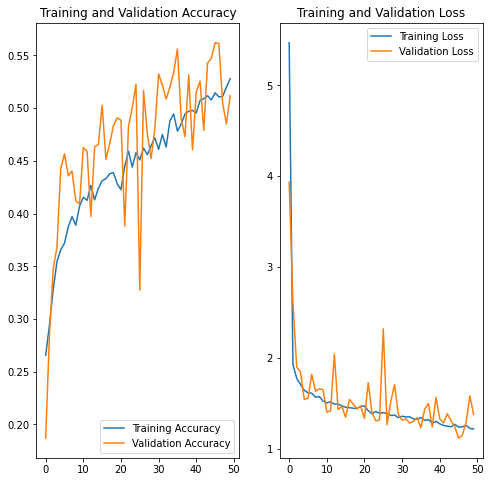

In [64]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

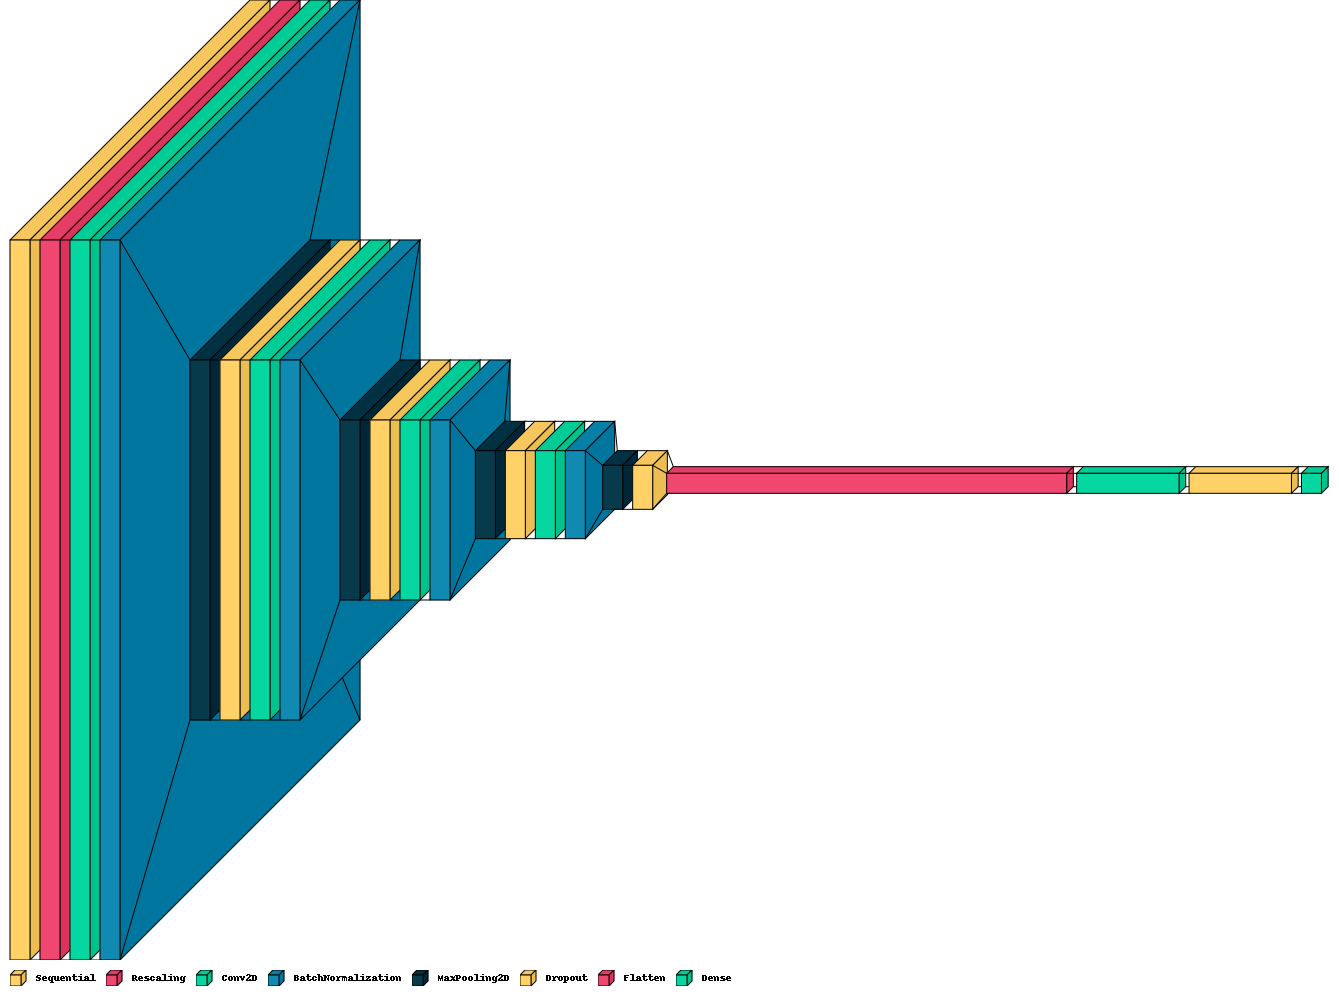

In [65]:
visualkeras.layered_view(model, legend=True)

#### Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?
loss: 1.1797 - accuracy: 0.5473 - val_loss: 1.1656 - val_accuracy: 0.6065
Data rebalance helped with getting model better. There is no overfittig or underfitting, But model can be improved a lot since accuracy of 60% is not good enough for this type of application.
One way to do this is increase number of features, Add more layers or train the model on more data.


### Model evaluation

In [66]:
test_dataset = tf.keras.utils.image_dataset_from_directory(data_dir_test, image_size=(img_height, img_width), 
                                           batch_size=batch_size)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

Found 118 files belonging to 9 classes.


Predictions:
 [0 0 0 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0
 0 0 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 1 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0
 0 0 1 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 1 1
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 1 0]
Labels:
 [5 3 3 2 6 4 1 3 7 7 1 3 1 4 4 3 4 7 7 7 5 5 6 1 4 8 5 8 5 2 5 7]


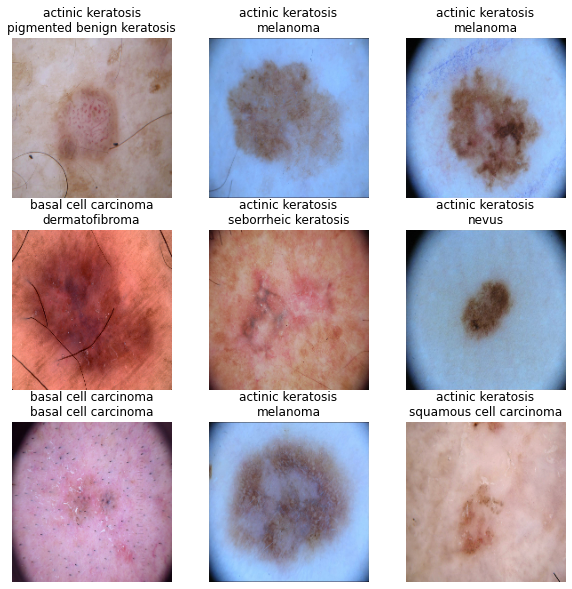

In [72]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.55, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(class_names[predictions[i]] + "\n" + class_names[label_batch[i]])
    plt.axis("off")